In [25]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import statsmodels.api as sm
import datetime
import pickle
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


data = pd.read_csv('data/processed/arima_df.csv').set_index('date')
data

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 14959.893465091778
MAE: 11265.335750098899
R2 Score: 0.9835642876259857


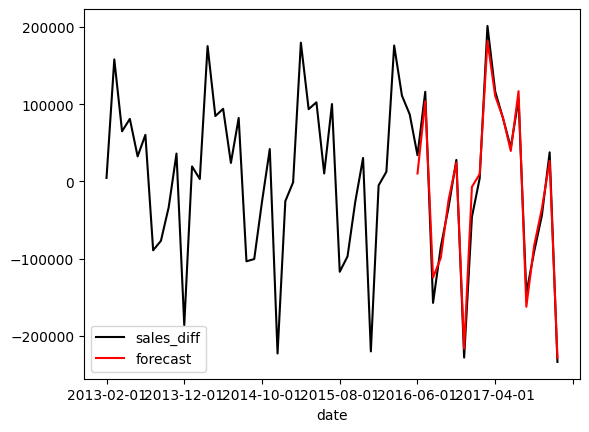

In [26]:
# Model
sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

# Predictions
start, end, dynamic = 40, 100, 7
data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
pred_df = data.forecast[start+dynamic:end]

data[['sales_diff', 'forecast']].plot(color=['black', 'Red'])

model_scores = {}

rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
model_scores['ARIMA'] = [rmse, mae, r2]

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

pickle.dump(model_scores, open( "model/arima_model_scores.p", "wb" ))

In [27]:
# from pmdarima.arima import auto_arima
# from pmdarima.arima import AutoARIMA

# stepwise_model = auto_arima(
#     data.sales_diff, 
#     start_P=0,  max_P=0,
#     start_D=0, max_D=10,
#     start_Q=0, max_Q=0,  
#     start_p=1, max_p=10,
#     start_d=0, max_d=10,
#     start_q=0, max_q=10,
#     seasonal=True, d=0, 
#     trace=True, 
#     suppress_warnings=True, stepwise=False
# )
# print(stepwise_model.aic())

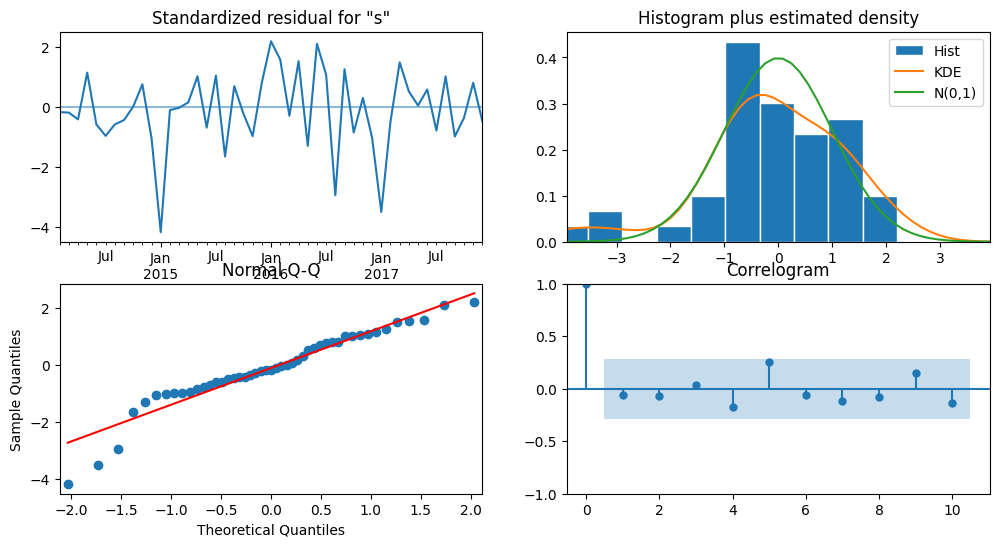

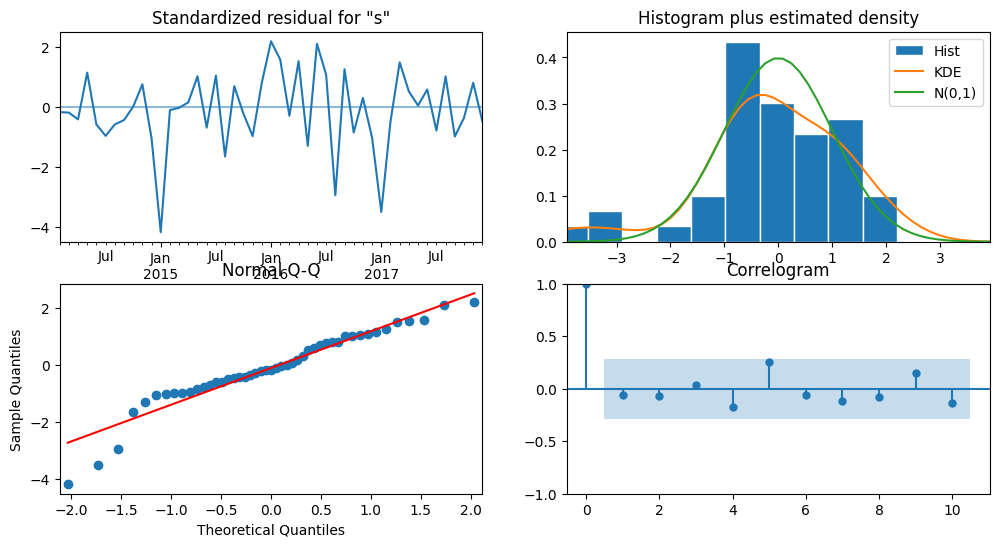

In [28]:
sar.plot_diagnostics(figsize=(12, 6))

C:\Users\klaud\AppData\Local\Temp\ipykernel_15808\3057922207.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])


TypeError: lineplot() got multiple values for argument 'data'

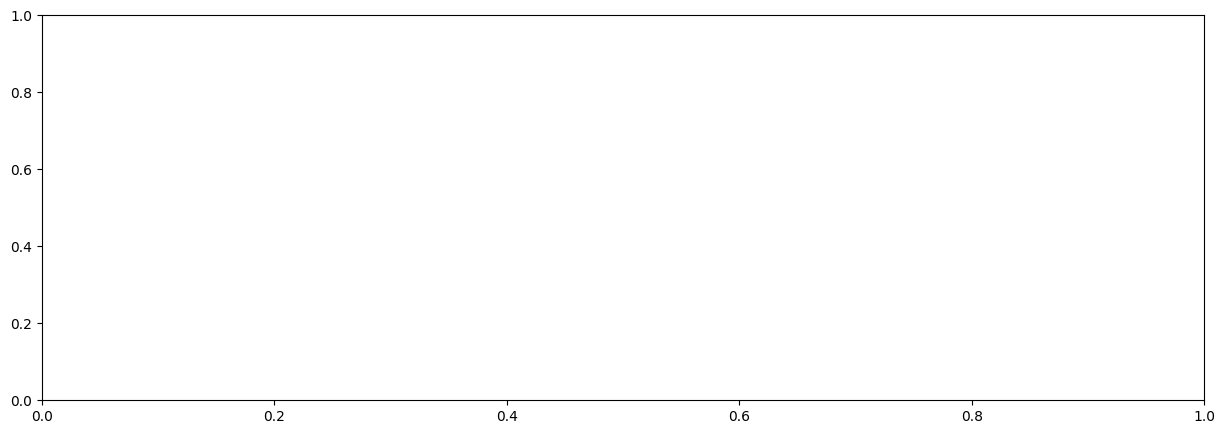

In [29]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.date, y=original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'model/{model_name}_forecast.png')

prediction_df, original_df = predict_df(pred_df)
plot_results(prediction_df, original_df, 'arima')